In [18]:
# Script for convert lon, lat to tile coords for download link
# GET http(s)://({abcd}.)data.osmbuildings.org/0.2/anonymous/tile/15/{x}/{y}.json
# https://data.osmbuildings.org/0.2/anonymous/tile/15/17605/10743.json

import math

def long_to_x(longitude, zoom):
    return int((longitude + 180.0) / 360.0 * (2.0 ** zoom))

def lat_to_y(latitude, zoom):
    return int((1.0 - math.log(math.tan(math.radians(latitude)) + 1 / math.cos(math.radians(latitude))) / math.pi) / 2.0 * (2.0 ** zoom))

longitude = 13.414041  # Your longitude
latitude = 52.537443  # Your latitude
zoom = 15  # Your zoom level

x = long_to_x(longitude, zoom)
y = lat_to_y(latitude, zoom)
print(x, y)

17604 10743


In [19]:
# Show geojson map
import folium

# Create a Map instance
m = folium.Map(location=[52.537443, 13.414041], zoom_start=16)

# Load GeoJSON file
folium.GeoJson(
    "export.geojson",
    name='geojson'
).add_to(m)

# Show the map
m


In [20]:
# Script to generate xml file for simulation use in omnet++/inet
# downloaded filename is export.geojson

import json
import math
from xml.etree.ElementTree import Element, SubElement, tostring, ElementTree
from xml.dom import minidom
import pyproj
import numpy as np
from tqdm import tqdm

# Radius of the Earth in km
R = 6371

# Function to convert lat/lon to metric
def lat_lon_to_metric(lat, lon, min_lat, min_lon):
    x = (lon - min_lon) * math.cos(min_lat) * R * math.pi / 180
    y = (lat - min_lat) * R * math.pi / 180
    return x * 1000, y * 1000  # convert to meters

# # Convert GPS coordinates to Cartesian coordinates
def to_cartesian(lat, lon):
    # Calculate UTM zone from longitude
    zone = int((lon + 180) / 6) + 1
    # Determine if the point is in the Northern or Southern hemisphere
    hemisphere = 'north' if lat >= 0 else 'south'

    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs("epsg:4326", f"epsg:326{zone if lat >= 0 else zone + 100}")

    x, y = transformer.transform(lat, lon)
    return x, y

# Helper function to extract all points in the geojson
def get_points(geometry):
    if geometry['type'] == 'Polygon':
        return geometry['coordinates'][0]
    elif geometry['type'] == 'MultiPolygon':
        return [pt for polygon in geometry['coordinates'] for pt in polygon[0]]

# Parse the GeoJSON
with open("export.geojson") as f:
    geojson = json.load(f)

# Get the minimum latitude and longitude
min_lat = 10**5
for feat in geojson["features"]:
    for p in get_points(feat["geometry"]):
        min_lat = min(min_lat, p[1])
min_lon = 10**5
for feat in geojson["features"]:
    for p in get_points(feat["geometry"]):
        min_lon = min(min_lon, p[0])

min_x, min_y = to_cartesian(min_lat, min_lon)

# Create the root element
root = Element('environment')

# Prepare node locations
node_locations = []
polygon_position = [] # for analysis

# Loop through the features
for feature in tqdm(geojson['features']):
    # Only process polygons
    if feature['geometry']['type'] in ('Polygon', 'MultiPolygon'):
        # Create the object element
        obj = SubElement(root, 'object')
        
        # Set object attributes
        height = feature['properties'].get('height', 10)  # Use height from properties or default to 10
        
        # Convert the coordinates to metric and generate the shape attribute
        shape_coords = []
        metric_coords = []
        for coords in get_points(feature['geometry']):
            # x, y = lat_lon_to_metric(coords[1], coords[0], min_lat, min_lon)
            x, y = to_cartesian(coords[1], coords[0])
            x, y = x-min_x, y-min_y
            metric_coords.append([x, y])
            shape_coords.append(f"{x} {y} ")

        min_metric_coords = np.min(metric_coords, axis=0)
        obj.set('position', f"min {min_metric_coords[0]} {min_metric_coords[1]} 0")

        node_locations.append(list(min_metric_coords)+[height+1])
        for c in metric_coords:
            polygon_position.append(c)

        shape = f"prism {height} " + ' '.join(shape_coords)
        obj.set('shape', shape)
        
        obj.set('material', "brick")
        obj.set('fill-color', "203 65 84")
        obj.set('opacity', "0.8")

# Generate the XML string
xml_string = tostring(root)

# Pretty print the XML
xml_pretty = minidom.parseString(xml_string).toprettyxml(indent="   ")

# Write XML string to file
with open('buildings_pyproj.xml', 'w') as f:
    f.write(xml_pretty)
    
#print(xml_pretty)
print(node_locations)


100%|██████████| 630/630 [10:54<00:00,  1.04s/it]

[[50.37154285929864, 162.55148352403194, 8.8], [145.24812813050812, 172.7600419903174, 19], [93.73804169904906, 173.99363484978676, 10], [140.93806551699527, 261.42216833215207, 19], [6.670891115092672, 297.7895908020437, 29.2], [44.04450916900532, 344.29984499234706, 16.3], [61.541475241596345, 379.9763156855479, 25.3], [51.94087708968436, 452.39060141611844, 8.5], [55.09505570161855, 712.4602618822828, 16], [64.41704531799769, 740.8756389794871, 16], [112.31783365446609, 565.130731927231, 23], [52.457999596896116, 441.45712246000767, 13.7], [514.5909112507361, 15.825337427668273, 19], [440.9341677146149, 51.127115237526596, 23], [495.88297807599884, 49.94860265776515, 19], [503.3956573699834, 51.98426859173924, 19], [512.2479831295786, 70.55830763559788, 19], [442.50126328202896, 82.47947810217738, 23], [541.0161423355457, 85.8045915486291, 21.1], [519.4722553309402, 95.62496761418879, 19], [452.03645842848346, 97.44238525163382, 23], [526.7667415679316, 101.87393723148853, 19], [555

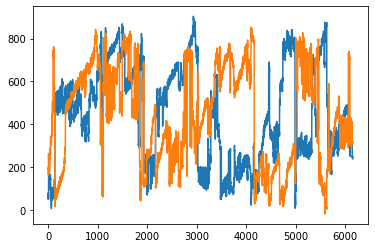

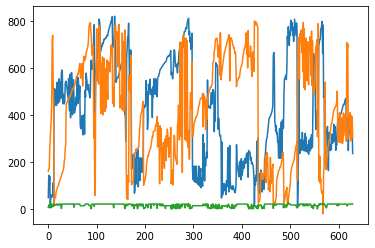

[451.83217585 443.97168524]
[452.29041308 426.74945106]


In [21]:
# Print node locations
import matplotlib.pyplot as plt
plt.plot(polygon_position)
plt.show()
plt.plot(node_locations)
plt.show()

print(np.mean(polygon_position, axis=0))
print(np.max(polygon_position, axis=0)/2)

In [25]:
import random
import math

random.seed(1)

with open('node_locations_gw200m.txt', 'w') as f:
    node_num = 10
    gw_x = 452
    gw_y = 426
    gw_z = 200
    f.write("**.loRaGW[0].**.initialX = " + str(gw_x) + "m\n")
    f.write("**.loRaGW[0].**.initialY = " + str(gw_y) + "m\n")
    f.write("**.loRaGW[0].**.initialZ = " + str(gw_z) + "m\n")
    locations = []
    distances = []
    indexes = random.sample(range(len(node_locations)), node_num)
    print(indexes)
    for i in range(node_num):
        x, y, z = node_locations[indexes[i]]
        locations.append([x,y,z])
        distances.append(math.sqrt((gw_x-x)**2 + (gw_y-y)**2 + (gw_z-z)**2))
        f.write("**.loRaNodes[" + str(i) + "].**.initialX = " + str(x) + "m\n")
        f.write("**.loRaNodes[" + str(i) + "].**.initialY = " + str(y) + "m\n")
        f.write("**.loRaNodes[" + str(i) + "].**.initialZ = " + str(z) + "m\n")
    f.write(str(locations)+"\n")
    f.write(str(distances)+"\n")



[137, 582, 64, 261, 120, 507, 460, 483, 388, 214]


In [42]:
# generate gps coordinates of each nodes for multilateration analysis
import pyproj

def to_gps(x, y, zone, hemisphere):
    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs(f"epsg:326{zone if hemisphere == 'north' else zone + 100}", "epsg:4326")
    
    lat, lon = transformer.transform(x, y)
    return [lat, lon]

zone = int((13.414041 + 180) / 6) + 1

locations_gps = []
for i in range(len(locations)):
    location_gps = to_gps(locations[i][0]+min_x, locations[i][1]+min_y, zone, 'north')
    location_gps.append(locations[i][2])
    locations_gps.append(tuple(location_gps))
print(locations_gps)
print(to_gps(gw_x+min_x, gw_y+min_y, zone, 'north'), gw_z)


[(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53863682156572, 13.423243543905807, 5.1), (52.54022829654233, 13.424028618727982, 23), (52.53768690920158, 13.423827698593255, 19), (52.53701243697258, 13.41926365424317, 23), (52.53765506974833, 13.416535624425991, 23), (52.540951204354315, 13.414768595630743, 19), (52.53846109447526, 13.42080118586715, 23)]
[52.53962045830213, 13.419884901364885] 200
